# Music Generation using Deep Learning

## Importing all the required libraries

In [45]:
import os
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding, GRU

Mount  the drive to read input data and to save files to the directory

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create required folders in your google drive
#### Main Folder - Deep_Learning_Project
#### Sub folders - 1) data
####               2) model
####                 a) GRU_iteration1
####                 b) LSTM_iteration2

In [47]:
DATA_DIR = '/content/drive/My Drive/Deep_Learning_Project/data/'
MODEL_DIR = '/content/drive/My Drive/Deep_Learning_Project/model/'
filename = 'input.txt'

In [48]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

## Defining Batches

In [49]:
# In this function we are creating batches with sequence length of 64 chars. 
# X consists of indices of characters for each of the sequence
# Y is a tensor which is a on hot encoded value corresponding to the index of next character
def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y

# Final Model - Multi stack LSTM Model

## Model Architecture

In [50]:
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

###########################################################################################################################
## The hidden state has multiple LSTM units(256). Same input goes to all the LSTM units, each of the LSTM will learn different 
## aspects of the input characters. Output of each LSTM goes to next timestamp

## return_sequences=True --- By default this parameter is false for LSTM. If we make it True, for every LSTM unit
##                           if we want it to generate an output we have to set this parameter to True. 
##                           Usually for many-many artchitectures this parameter is true

## TimeDistributed Dense layer --- After every timestep if we want to create a dense layer then we use this parameter. 
##                                 It is similar to an MLP with 86 neurons i.e. vocab_size

## stateful=True --- Default value is False. BUt if True then we are giving output of 'Batch 1_First row' as input to 'Batch 2_First row'
##                   Essentialluy RNN will learn data from 0 to 8103 with continuity

## LSTM Documentation: https://keras.io/api/layers/recurrent_layers/lstm/
##                     https://keras.io/models/sequential/
###########################################################################################################################

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    
    return model

#if __name__ == '__main__':
    #model = build_model(16, 64, 50)
    #model.summary()

## Model Training function

In [51]:
#### text has the data pressent in input.txt file, # of epochs is 100, after every 10 epochs we are saving the model
def train(text, epochs=100, save_freq=10):

    # Sorting the characters in the text file and assigning index numbers to each character. 
    # char_to_idx will be a dictionary of unique characters as key and index number is the value pair of dictionary
    # To summarize we are comverting each character to a numerical index
    
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    ## Saving the char_to_idx to a json file
    with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    #3 Here we are creating index to character mapping, i.e. given an index we want to get the character for that index
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    ######################################
    ######### Model architecture #########
    ######################################
    
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    ###################################
    ###### Train data generation ######
    ###################################
    
    #convert complete text into numerical indices
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int64)

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  
    
    epc,losses, accs = [], [], []
    ### This for loop will run for 100 epochs
    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        

        # For each epoch it will generate a batch of X , Y values. For each batch we will train the model. 
        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            #print(X);
            
            ## Details about train_on_batch here: https://keras.io/models/sequential/
            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            epc.append(epoch + 1)
            losses.append(loss)
            accs.append(acc)
        
      
        # Saving the model after every 10 epochs
        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))
    
    df1 = pd.DataFrame(epc)
    df2 = pd.DataFrame(losses)
    df3 = pd.DataFrame(accs)
    frames = [df1,df2, df3]

    result = pd.concat(frames, axis =1)
    result.columns=['Epoch','Losses','Accuracy']

    grouped_multiple = result.groupby(['Epoch'], as_index=False).agg({'Losses': 'mean'
                                              ,'Accuracy':'mean'})
    
    model.summary()
    
    return grouped_multiple


### Code for building a LSTM model to generate sample sequence of characters

In [52]:
def build_model_seq_gen(unique_chars):
    model = Sequential()
    model.add(Embedding(unique_chars, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(unique_chars))
    model.add(Activation('softmax'))
    plot_model(model, to_file='model.png')
    return model

## Code for Sample character sequence generator

In [53]:
def sample_seq_generator(epoch_num, character_index, seq_length):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    vocab_size = len(index_to_char)

    ##########################################################
    ######### Sequence generator model architecture  #########
    ##########################################################
    
    model = build_model_seq_gen(vocab_size)
    model.load_weights(MODEL_DIR + 'weights.{}.h5'.format(epoch_num))
     
    sequence_index = [character_index]
    
    for _ in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict(batch).reshape(-1)
        #print(predicted_probs)
        sample = np.random.choice(range(vocab_size), size = 1, p = predicted_probs)
        
        sequence_index.append(sample[0])
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    return seq

## Code to call Train function

In [54]:
if __name__ == '__main__':
    epochs = 100
    freq = 10
    
    ### Calling the train function to read the data from input.txt file 
    Train_epoch_loss_acc = train(open(os.path.join(DATA_DIR, filename)).read(), epochs, freq)

Streaming output truncated to the last 5000 lines.
Batch 21: loss = 0.40900716185569763, acc = 0.8642578125
Batch 22: loss = 0.38351723551750183, acc = 0.8544921875
Batch 23: loss = 0.38637539744377136, acc = 0.857421875
Batch 24: loss = 0.3574186861515045, acc = 0.8818359375
Batch 25: loss = 0.3797234296798706, acc = 0.869140625
Batch 26: loss = 0.3453875780105591, acc = 0.8828125
Batch 27: loss = 0.40357375144958496, acc = 0.8759765625
Batch 28: loss = 0.37052303552627563, acc = 0.869140625
Batch 29: loss = 0.3803356885910034, acc = 0.8603515625
Batch 30: loss = 0.3422233462333679, acc = 0.880859375
Batch 31: loss = 0.3837091028690338, acc = 0.8759765625
Batch 32: loss = 0.4639955759048462, acc = 0.8447265625
Batch 33: loss = 0.33672571182250977, acc = 0.89453125
Batch 34: loss = 0.3752266764640808, acc = 0.8779296875
Batch 35: loss = 0.3481239080429077, acc = 0.8828125
Batch 36: loss = 0.3128468990325928, acc = 0.90234375
Batch 37: loss = 0.31583595275878906, acc = 0.890625
Batch 38

## Training Loss & Accuracy
### We can find the epoch number from these graphs to choose the optimal weights to give as an input for sample sequence generator model

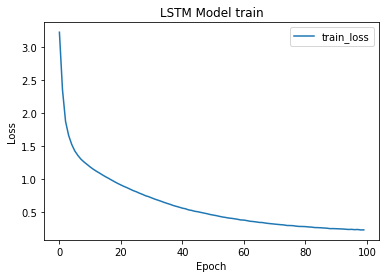

In [55]:
plt.plot(Train_epoch_loss_acc['Losses'])
plt.title('LSTM Model train')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss'], loc='upper right')

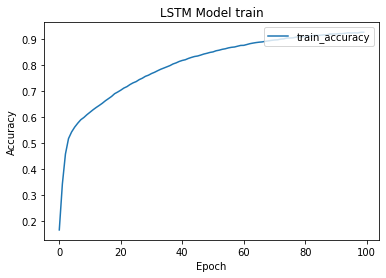

In [56]:
plt.plot(Train_epoch_loss_acc['Accuracy'])
plt.title('LSTM Model train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy'], loc='upper right')

plt.show()

## Model Output
### Please enter input values for epoch number, starting character index, sequence length

In [58]:
epoch_number = int(input("Enter epoch number between 1 to 100 only multiples of 10: "))
character_index = int(input("Enter any number between 0 to 86 to sequence generation: "))
Sequence_length = int(input("Number of characters to generate: "))

Generated_music_sequence = sample_seq_generator(epoch_number, character_index, Sequence_length)

print("\n")

print(Generated_music_sequence)

Enter epoch number between 1 to 100 only multiples of 10: 100
Enter any number between 0 to 86 to sequence generation: 1
Number of characters to generate: 600


 Dogs) Wide
% Nottingham Music Database
S:Trad, via EF
M:6/8
K:D
"D"F3 "A7/e"FED|"D/f+"FAA A2d|"G"BdB "D/f+"AFD|"G"DFG "A7"EFG|"D"FDD D2|


X: 277
T:Scramble Pilcring
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
A|"D"d2d "A"edc|"D"d2A F2A|"G"B2c dBG|"D"A2A "A7"GFE|
"D"DEF "A"EFG|"D"F2D D2d|"A7"cdc cBA|"D"d2A F2A|"G"B2c dcB|"A7"ABG "D"F2E|
"D"DFA d2A|"G"B2A Bcd|"C"e2G "G"d2:|
P:B
d|"D"AFD DFA|"D"d^cd "A"efe|"D"edc "G"B2A|"D"A3 -AFA|"G"B2B BAG|
"D"A2A AFA|"G"G2A Bdc|"D"A3 -AFA|"G"B2B Bcd|
"D"A2d f2a|"A"f2e c2e|"D"f2d "G"gfe|"D"f2d "A7"edc|"D"d3 -d2:|
A|"D"f2d faf|"D"d2f afd|"G"d2e 


## Model Architecure visualization

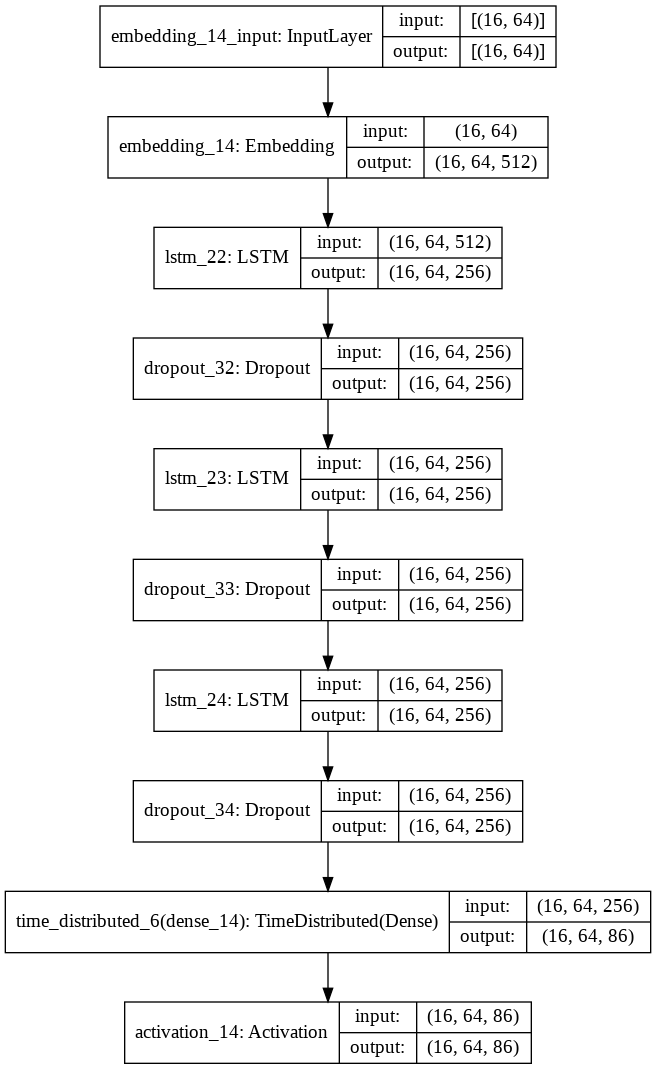

In [59]:
model = Sequential()
model.add(Embedding(86, 512, batch_input_shape=(16, 64)))
for i in range(3):
  model.add(LSTM(256, return_sequences=True, stateful=True))
  model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(86))) 
model.add(Activation('softmax'))
plot_model(model, to_file='LSTM_model.png',show_shapes=True, show_layer_names=True)

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Additional work - Expermineting with various architectures

# GRU - Multi stack model

## Model architecture

In [60]:
MODEL_DIR = '/content/drive/My Drive/Deep_Learning_Project/model/GRU_iteration1'

In [61]:
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'gru_weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'gru_weights.{}.h5'.format(epoch)))

def build_model_gru(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(GRU(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

## GRU model training function

In [62]:
#### text has the data pressent in input.txt file, # of epochs is 100, after every 10 epochs we are saving the model
def train_gru(text, epochs=100, save_freq=10):

    # Sorting the characters in the text file and assigning index numbers to each character. 
    # char_to_idx will be a dictionary of unique characters as key and index number is the value pair of dictionary
    # To summarize we are comverting each character to a numerical index
    
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    ## Saving the char_to_idx to a json file
    with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    #3 Here we are creating index to character mapping, i.e. given an index we want to get the character for that index
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    ######################################
    ######### Model architecture #########
    ######################################
    
    model = build_model_gru(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    ###################################
    ###### Train data generation ######
    ###################################
    
    #convert complete text into numerical indices
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int64)

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  
    
    epc,losses, accs = [], [], []
    ### This for loop will run for 100 epochs
    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        

        # For each epoch it will generate a batch of X , Y values. For each batch we will train the model. 
        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            #print(X);
            
            ## Details about train_on_batch here: https://keras.io/models/sequential/
            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            epc.append(epoch + 1)
            losses.append(loss)
            accs.append(acc)
        
      
        # Saving the model after every 10 epochs
        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'gru_weights.{}.h5'.format(epoch + 1))
    
    df1 = pd.DataFrame(epc)
    df2 = pd.DataFrame(losses)
    df3 = pd.DataFrame(accs)
    frames = [df1,df2, df3]

    result = pd.concat(frames, axis =1)
    result.columns=['Epoch','Losses','Accuracy']

    grouped_multiple = result.groupby(['Epoch'], as_index=False).agg({'Losses': 'mean'
                                              ,'Accuracy':'mean'})
    
    return grouped_multiple


## Code for building a GRU model to generate sample sequence of characters

In [63]:
def build_model_seq_gen_gru(unique_chars):
    model = Sequential()
    model.add(Embedding(unique_chars, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(GRU(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(unique_chars))
    model.add(Activation('softmax'))
    return model

## Sample sequence generator

In [64]:
def sample_seq_generator_gru(epoch_num, character_index, seq_length):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    vocab_size = len(index_to_char)

    ##########################################################
    ######### Sequence generator model architecture  #########
    ##########################################################
    
    model = build_model_seq_gen_gru(vocab_size)
    model.load_weights(MODEL_DIR + '/gru_weights.{}.h5'.format(epoch_num))
     
    sequence_index = [character_index]
    
    for _ in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict(batch).reshape(-1)
        #print(predicted_probs)
        sample = np.random.choice(range(vocab_size), size = 1, p = predicted_probs)
        
        sequence_index.append(sample[0])
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    return seq

## Calling Train function

In [65]:
if __name__ == '__main__':
    epochs = 100
    freq = 10
    
    ### Calling the train function to read the data from input.txt file 
    Train_epoch_loss_acc_gru = train_gru(open(os.path.join(DATA_DIR, filename)).read(), epochs, freq)

Streaming output truncated to the last 5000 lines.
Batch 123: loss = 0.4293166399002075, acc = 0.8603515625
Batch 124: loss = 0.46637892723083496, acc = 0.8447265625
Batch 125: loss = 0.42210620641708374, acc = 0.859375
Batch 126: loss = 0.4782896935939789, acc = 0.849609375

Epoch 62/100
Batch 1: loss = 0.49956852197647095, acc = 0.8408203125
Batch 2: loss = 0.463256299495697, acc = 0.845703125
Batch 3: loss = 0.4390028119087219, acc = 0.8642578125
Batch 4: loss = 0.40432220697402954, acc = 0.8740234375
Batch 5: loss = 0.4261327385902405, acc = 0.8564453125
Batch 6: loss = 0.47348666191101074, acc = 0.8427734375
Batch 7: loss = 0.4268985986709595, acc = 0.8486328125
Batch 8: loss = 0.44006621837615967, acc = 0.8466796875
Batch 9: loss = 0.41902056336402893, acc = 0.8671875
Batch 10: loss = 0.3559955656528473, acc = 0.8818359375
Batch 11: loss = 0.3810996413230896, acc = 0.8671875
Batch 12: loss = 0.42374372482299805, acc = 0.865234375
Batch 13: loss = 0.42782360315322876, acc = 0.8554

## Model Output

### Run below code and enter epoch number , starting character index, sequence lenght

In [66]:
epoch_number = int(input("Enter epoch number between 1 to 100 only multiples of 10: "))
character_index = int(input("Enter any number between 0 to 86 to sequence generation: "))
Sequence_length = int(input("Number of characters to generate: "))

Generated_music_sequence_gru = sample_seq_generator_gru(epoch_number, character_index, Sequence_length)

print("\n")

print(Generated_music_sequence_gru)

Enter epoch number between 1 to 100 only multiples of 10: 100
Enter any number between 0 to 86 to sequence generation: 1
Number of characters to generate: 600


 N74
T:The Lacking Corks
% Nottingham Music Database
S:NPTB, via EF
Y:AB
M:6/8
K:A
P:A
E|"A"A2A AGA|"G"B2G "D"A2A|"G"Bcd "A"ecA|"G"BAG "A"A3:|
P:B
"A"age "D"fga|"A"efe ece|"D"fga "A"edc|"D"d3 :|


X: 297
T:Spenleft 1,y Ronushan
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:A
"E7"GAB |"A"c2e "E7"B2e|"A"Ace cAB|"A"c2e "E7"B2e|"A"A3 |:"D"d2f a2f|"A"efe ece|"Bm"f2d f2d|"E"f3 "A"c2e|
"A"Ace ecA|"D"d2f a2f|"A"efe cBA|"Bm"dcd "E7"Bcd|"A"c3 -ceg|"Bm"f2d "E7"c2B|
"A"Ace cde|"D"fgf fga|"A"ecA AcB|A2A AAc|"Bm"Bcd "E7"c2B|
"A"A2c cde|"D"f2d fga|"A"cdc cBc|"A"Ace "D"agf|"A"efe "E7"e2d|\
"A"c2A "


# **Single layer LSTM Model**
### In this iteration we expermiented with single layer LSTM with 256 LSTM units

In [67]:
MODEL_DIR = '/content/drive/My Drive/Deep_Learning_Project/model/LSTM_iteration2'

## Model Architecture

In Iteration 2 we have considered only  1 LSTM layer

In [68]:
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 256, batch_input_shape=(batch_size, seq_len)))
    model.add(LSTM(256, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    
    return model

## Single layer LSTM Training function

In [69]:
def train(text, epochs=100, save_freq=10):

    # Sorting the characters in the text file and assigning index numbers to each character. 
    # char_to_idx will be a dictionary of unique characters as key and index number is the value pair of dictionary
    # To summarize we are comverting each character to a numerical index
    
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    ## Saving the char_to_idx to a json file
    with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    #3 Here we are creating index to character mapping, i.e. given an index we want to get the character for that index
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    ######################################
    ######### Model architecture #########
    ######################################
    
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    ###################################
    ###### Train data generation ######
    ###################################
    
    #convert complete text into numerical indices
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int64)

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  
    
    epc,losses, accs = [], [], []
    ### This for loop will run for 100 epochs
    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        

        # For each epoch it will generate a batch of X , Y values. For each batch we will train the model. 
        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            #print(X);
            
            ## Details about train_on_batch here: https://keras.io/models/sequential/
            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            epc.append(epoch + 1)
            losses.append(loss)
            accs.append(acc)
        
      
        # Saving the model after every 10 epochs
        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))
    
    df1 = pd.DataFrame(epc)
    df2 = pd.DataFrame(losses)
    df3 = pd.DataFrame(accs)
    frames = [df1,df2, df3]

    result = pd.concat(frames, axis =1)
    result.columns=['Epoch','Losses','Accuracy']

    grouped_multiple = result.groupby(['Epoch'], as_index=False).agg({'Losses': 'mean'
                                              ,'Accuracy':'mean'})
    
    model.summary()
    
    return grouped_multiple

## Sequence generator build function

In [70]:
def build_model_seq_gen(unique_chars):
    model = Sequential()
    model.add(Embedding(unique_chars, 256, batch_input_shape=(1, 1)))
    model.add(LSTM(256, return_sequences=True, stateful=True))
    #model.add(Dropout(0.2))

    model.add(Dense(unique_chars))
    model.add(Activation('softmax'))
    plot_model(model, to_file='model.png')
    return model

## Code for generating sample character sequences

In [71]:
def sample_seq_generator(epoch_num, character_index, seq_length):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    vocab_size = len(index_to_char)

    ##########################################################
    ######### Sequence generator model architecture  #########
    ##########################################################
    
    model = build_model_seq_gen(vocab_size)
    model.load_weights(MODEL_DIR + '/weights.{}.h5'.format(epoch_num))
     
    sequence_index = [character_index]
    
    for _ in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict(batch).reshape(-1)
        #print(predicted_probs)
        sample = np.random.choice(range(vocab_size), size = 1, p = predicted_probs)
        
        sequence_index.append(sample[0])
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    return seq

## Calling Train function

In [72]:
if __name__ == '__main__':
    epochs = 100
    freq = 10
    
    ### Calling the train function to read the data from input.txt file 
    Train_epoch_loss_acc = train(open(os.path.join(DATA_DIR, filename)).read(), epochs, freq)

Streaming output truncated to the last 5000 lines.
Batch 13: loss = 0.3836827874183655, acc = 0.8720703125
Batch 14: loss = 0.3852841854095459, acc = 0.8740234375
Batch 15: loss = 0.3599187433719635, acc = 0.880859375
Batch 16: loss = 0.4484732151031494, acc = 0.84765625
Batch 17: loss = 0.43767279386520386, acc = 0.859375
Batch 18: loss = 0.4159946143627167, acc = 0.8603515625
Batch 19: loss = 0.39604824781417847, acc = 0.8701171875
Batch 20: loss = 0.4148021936416626, acc = 0.8681640625
Batch 21: loss = 0.3906278908252716, acc = 0.8740234375
Batch 22: loss = 0.4137052893638611, acc = 0.849609375
Batch 23: loss = 0.37692081928253174, acc = 0.8720703125
Batch 24: loss = 0.3445672392845154, acc = 0.880859375
Batch 25: loss = 0.40696319937705994, acc = 0.8623046875
Batch 26: loss = 0.3818502426147461, acc = 0.873046875
Batch 27: loss = 0.44986143708229065, acc = 0.8544921875
Batch 28: loss = 0.40830063819885254, acc = 0.8505859375
Batch 29: loss = 0.4129514694213867, acc = 0.865234375
Ba

## Traing Loss 

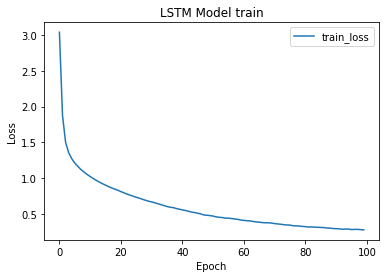

In [73]:
plt.plot(Train_epoch_loss_acc['Losses'])
plt.title('LSTM Model train')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss'], loc='upper right')

## Model Output
### Enter epoch number to select desired weights of that epoch, starting character index, length of output characters

In [74]:
epoch_number = int(input("Enter epoch number between 1 to 100 only multiples of 10: "))
character_index = int(input("Enter any number between 0 to 86 to sequence generation: "))
Sequence_length = int(input("Number of characters to generate: "))

Generated_music_sequence = sample_seq_generator(epoch_number, character_index, Sequence_length)

print("\n")

print(Generated_music_sequence)

Enter epoch number between 1 to 100 only multiples of 10: 100
Enter any number between 0 to 86 to sequence generation: 1
Number of characters to generate: 600


 [1"F""F#7"k'3 fe|"Bb"d3 -d3|"F"A2B "C7"_ed|"F"c3 -cAF||
|:"C"c3 c3|c3 -c3||


X: 100
T:Raisher's Brigg
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
|:d|"G"d2g gfe|dgd B3|"Am"cBc "D7"A2c|"G"Bdd dgg|
"Am"ecA Ace|"D"fef fed|"A7"ABc ABc|"D"d3 -d2||


X: 129
T:The Maggan's Aanbarie
% Nottingham Music Database
S:Bob McQuillen 19 976, via Phil Rowe
M:6/8
K:C
G3 |"C"cBc G^FG|CGE C3|"C"EG^F "G7"G2B|"C"e^de c2B|
"F"AyA A2G|"F"FGA "D7"AFA|"Gm"G3 G2:|


X: 81
T:Dan Hunting
% Nottingham Music Database
S:Dennis Salter, via Phil Rowe
M:6/8
K:G
D2|:"G"GFG "D7"A2F|"G"GAB "C"d2c|"G"Bdg "Am"ecA|"D
